# Implementation of the Boruta Feature Selection Algorithm

In [1]:
# important libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [99]:
from imblearn.over_sampling import RandomOverSampler

## Reading and processing the data

In [2]:
data =  pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data processing
 
- Removing NaNs
- Convert categorical variables to numeric representation
- Drop Useless columns


In [4]:
# converting to numeric
data["gender"] = pd.factorize(data["gender"])[0]
data["ever_married"] = pd.factorize(data["ever_married"])[0]
data["work_type"] = pd.factorize(data["work_type"])[0]
data["Residence_type"] = pd.factorize(data["Residence_type"])[0]
data["smoking_status"] = pd.factorize(data["smoking_status"])[0]
# additional cleaning
data.dropna(inplace =True)
data.drop("id", axis =1, inplace = True)
data.reset_index(inplace=True, drop=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,0,80.0,0,1,0,0,1,105.92,32.5,1,1
2,1,49.0,0,0,0,0,0,171.23,34.4,2,1
3,1,79.0,1,0,0,1,1,174.12,24.0,1,1
4,0,81.0,0,0,0,0,0,186.21,29.0,0,1


Seperate Input and Output columns

In [100]:
X = np.load("/data/jand/sixthTool/data/linear_features/point/benchmark/train/k4p10nor2n10_train.npy")
# X = np.load("/data/jand/sixthTool/data/linear_features/point/benchmark/train/k8n10nor0_train.npy")
# X = X.reshape(len(X), -1)
# y = np.load("/data/jand/sixthTool/data/linear_features/point/benchmark/train/k8_train_y.npy")
y = np.load("/data/jand/sixthTool/data/linear_features/point/benchmark/train/train_y.npy")

In [85]:
X = np.load("/data/jand/sixthTool/data/linear_features/1108/benchmark_mRNA/train/k4n10nor0.npy")
y = np.load("/data/jand/sixthTool/data/linear_features/1108/benchmark_mRNA/train/y.npy")

In [101]:
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

In [102]:
X.shape

(3964, 2560)

In [103]:
X = pd.DataFrame(X)

In [104]:
X[X[0].isna()]

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559


In [ ]:
# seperate input and output variables
X = data.drop("stroke", axis = 1)
y = data["stroke"]

## Create shadow features

Shadow features are created by randomly shuffling the original features (row-by-row).

Each shuffled feature is then appended back to the original dataset

In [105]:
shadow_X = pd.DataFrame([])

In [106]:
for col in X.columns:
    # print(col)
    # X[col].sample(frac=1).reset_index(drop=True)
    shadow_X[f"shadow_{col}"] = X[col].sample(frac=1).reset_index(drop=True)

In [107]:
X = X.join(shadow_X)

In [108]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,shadow_2550,shadow_2551,shadow_2552,shadow_2553,shadow_2554,shadow_2555,shadow_2556,shadow_2557,shadow_2558,shadow_2559
0,0.003115,0.003066,0.002957,0.002918,0.002984,0.002969,0.002906,0.002937,0.002782,0.002593,...,0.003677,0.000299,0.002823,0.000000,0.000615,0.000000,0.003025,0.0,0.002390,0.000000
1,0.002478,0.002729,0.002977,0.003096,0.003168,0.003526,0.004302,0.005111,0.005657,0.006423,...,0.000000,0.000296,0.000000,0.000498,0.000670,0.001263,0.000000,0.0,0.001935,0.000000
2,0.000615,0.000774,0.000993,0.001283,0.001625,0.002162,0.002394,0.002040,0.001832,0.001760,...,0.000050,0.002349,0.000000,0.000000,0.001713,0.000000,0.000000,0.0,0.000000,0.000000
3,0.006582,0.006464,0.006725,0.006255,0.005702,0.005286,0.004699,0.004205,0.003880,0.003502,...,0.000000,0.000000,0.001275,0.001910,0.002426,0.003661,0.003656,0.0,0.001307,0.000809
4,0.004078,0.004034,0.004322,0.004612,0.005002,0.005405,0.005712,0.006339,0.007474,0.008389,...,0.000000,0.001153,0.000804,0.000000,0.000938,0.000000,0.000000,0.0,0.000000,0.002203


In [75]:
X.tail()

,0,1,2,3,4,5,6,7,8,9,...,shadow_2550,shadow_2551,shadow_2552,shadow_2553,shadow_2554,shadow_2555,shadow_2556,shadow_2557,shadow_2558,shadow_2559
8403,0.425508,0.264560,0.427271,0.537003,0.686466,0.990712,1.000000,0.652638,0.229438,0.0000,...,1.0,0.593524,0.257196,1.000000,0.808488,0.065321,0.177270,0.891853,0.768317,1.000000
8404,0.136478,0.030337,0.046679,0.090790,0.000000,0.029236,0.182394,0.441150,0.745169,1.0000,...,1.0,0.044390,0.044161,NaN,0.696509,0.725631,0.000000,0.075196,1.000000,0.901254
8405,0.000000,0.054389,0.139587,0.254636,0.348229,0.373536,0.459036,0.625964,0.856938,1.0000,...,NaN,NaN,0.075277,0.807084,0.317298,1.000000,0.492366,1.000000,NaN,NaN
8406,0.000000,0.099280,0.169537,0.272233,0.419621,0.416970,0.505143,0.692973,0.881958,1.0000,...,0.0,0.071152,0.770359,NaN,0.713913,0.454210,NaN,0.342942,1.000000,1.000000
8407,0.000000,0.275840,0.747069,1.000000,0.925469,0.896534,0.873312,0.928717,0.680325,0.4534,...,1.0,0.036300,0.950300,0.548054,NaN,0.243899,0.979547,0.884678,0.270162,1.000000


### Getting importance of features

The new (extended) dataset is then trained using a tree classifier (Random Forest in our case) and the feature importance it returns is stored.

Whatever is the most important *shadow* feature is taken as a threshold. Any feature above this threshold is considered **Important**. 

In [29]:
def get_important_features(X, y):
    # Initiliaze Random Forest CLassifier
    rf = RandomForestClassifier(max_depth=20)
    
    # Fit Random Forest on provided data
    rf.fit(X,y)
    
    # Create dictionary of feature importances
    importances = {feature_name: f_importance for feature_name, f_importance in zip(X.columns, rf.feature_importances_)}

    # Isolate importances of Shadow features
    only_shadow_feat_importance = {key:value for key,value in importances.items() if "shadow" in str(key)}
    
    # get importance level of most important shadow feature
    highest_shadow_feature = list(dict(sorted(only_shadow_feat_importance.items(), key=lambda item: item[1], reverse=True)).values())[0]
    
    # get original feature which fulfill boruta selection criteria
    selected_features = [key for key, value in importances.items() if value > highest_shadow_feature]
    
    
    return selected_features

### Multiple trials

Since any classifier randomly initialises its weight, it is important that we perform the trials enough times to see which features make it to the **Important Feature** zone. 

In [10]:
TRIALS = 50

In [109]:
feature_hits = {i:0 for i in X.columns}
for _ in tqdm(range(TRIALS)): 
    imp_features = get_important_features(X, y)
    for key, _ in feature_hits.items(): 
        if key in imp_features: feature_hits[key] += 1


  0%|          | 0/50 [00:00<?, ?it/s]

In [110]:
feature_hits

{0: 43,
 1: 41,
 2: 43,
 3: 40,
 4: 42,
 5: 39,
 6: 38,
 7: 36,
 8: 39,
 9: 42,
 10: 45,
 11: 44,
 12: 46,
 13: 46,
 14: 42,
 15: 49,
 16: 48,
 17: 42,
 18: 39,
 19: 38,
 20: 37,
 21: 39,
 22: 35,
 23: 38,
 24: 37,
 25: 44,
 26: 43,
 27: 48,
 28: 49,
 29: 41,
 30: 39,
 31: 35,
 32: 35,
 33: 41,
 34: 33,
 35: 40,
 36: 40,
 37: 43,
 38: 45,
 39: 45,
 40: 43,
 41: 47,
 42: 43,
 43: 45,
 44: 39,
 45: 40,
 46: 39,
 47: 40,
 48: 37,
 49: 38,
 50: 48,
 51: 46,
 52: 45,
 53: 44,
 54: 39,
 55: 38,
 56: 36,
 57: 37,
 58: 39,
 59: 40,
 60: 43,
 61: 47,
 62: 43,
 63: 47,
 64: 47,
 65: 47,
 66: 49,
 67: 48,
 68: 46,
 69: 45,
 70: 47,
 71: 46,
 72: 44,
 73: 41,
 74: 46,
 75: 46,
 76: 49,
 77: 42,
 78: 44,
 79: 40,
 80: 47,
 81: 47,
 82: 47,
 83: 42,
 84: 45,
 85: 46,
 86: 47,
 87: 45,
 88: 48,
 89: 47,
 90: 49,
 91: 49,
 92: 49,
 93: 50,
 94: 50,
 95: 50,
 96: 48,
 97: 48,
 98: 47,
 99: 45,
 100: 49,
 101: 49,
 102: 49,
 103: 50,
 104: 47,
 105: 46,
 106: 49,
 107: 44,
 108: 44,
 109: 47,
 110: 40,


### Binomial Distribution

When we conduct multiple trials of an event, a binomial distribution helps us determine the probabilistic significance of the number of trials.

In simpler terms, how many trials are significant to ensure our desired result.

In [111]:
# Calculate the probability mass function
pmf = [sp.stats.binom.pmf(x, TRIALS, .5) for x in range(TRIALS + 1)]

In [112]:
for i, x in enumerate(pmf):
    print(i, x)

0 8.881784197001244e-16
1 4.440892098500656e-14
2 1.0880185641326512e-12
3 1.7408297026121992e-11
4 2.0454749005693933e-10
5 1.8818369085237732e-09
6 1.4113776813928881e-08
7 8.87151685446952e-08
8 4.768440309277423e-07
9 2.225272144329438e-06
10 9.123615791750566e-06
11 3.3176784697275354e-05
12 0.00010782455026614331
13 0.0003151794546241225
14 0.0008329742729351492
15 0.0019991382550443837
16 0.0043731149329095925
17 0.008746229865818984
18 0.016034754754001852
19 0.027005902743581986
20 0.04185914925255192
21 0.05979878464650333
22 0.0788256706703891
23 0.09596168603351873
24 0.10795689678770784
25 0.11227517265921609
26 0.10795689678770784
27 0.09596168603351873
28 0.07882567067038895
29 0.05979878464650333
30 0.04185914925255199
31 0.027005902743581986
32 0.016034754754001825
33 0.008746229865818984
34 0.0043731149329096
35 0.0019991382550443837
36 0.0008329742729351477
37 0.0003151794546241225
38 0.0001078245502661435
39 3.3176784697275354e-05
40 9.123615791750566e-06
41 2.22527

In [43]:
# trails_in_green_zone
def get_tail_items(pmf):
    total = 0
    for i, x in enumerate(pmf):
        total += x
        if total >= 0.05:
            break
    return i

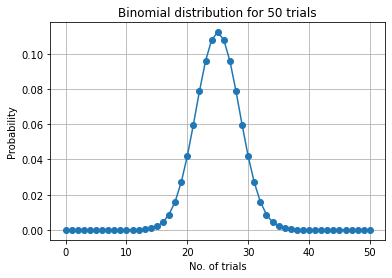

In [33]:
# plot the binomial distribution
plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
plt.title(f"Binomial distribution for {TRIALS} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.grid(True)

Now we define features are either **extremely important, moderately important or completely unimportant**.

General rule is that: 
- *Extremely Important* features are kept.
- *Moderately Important* features can be played around with
- *Unimportant* features are removed



In [95]:
# select features from n number of trials
def choose_features(feature_hits, TRIALS, thresh):
    
    #define boundries
    green_zone_thresh = TRIALS - thresh
    blue_zone_upper = green_zone_thresh
    blue_zone_lower = thresh
    
    green_zone = [key for key, value in feature_hits.items() if value >= green_zone_thresh]
    blue_zone = [key for key, value in feature_hits.items() if (value >= blue_zone_lower and value < blue_zone_upper)]
    
    return green_zone, blue_zone

In [113]:
thresh = get_tail_items(pmf)
green, blue = choose_features(feature_hits, TRIALS, thresh)

In [117]:
X.shape

(3964, 5120)

In [116]:
len(green)

2369

In [114]:
green,blue

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15